Uvozimo pakete

In [14]:
import main
import pandas as pd
from spremenljivke import *
from collections import Counter
%matplotlib inline

Pridobimo željene podatke

In [2]:
# main.main(True, True, prva_stran, zadnja_stran)

Poglejmo si razpredelnivco pridobljenih podatkov

In [3]:
razpredelnica

,ime,oblika,vrsta,tonemski_naglas
0,á,--,samostalnik moškega spola,ā
1,à,à,samostalnik moškega spola,ȃ
2,abalienácija,-e,samostalnik ženskega spola,á
3,abalienacíjski,-a -o,pridevnik,ȋ
4,abbé,-ja,samostalnik moškega spola,ẹ̑ ȇ
...,...,...,...,...
1792,armáda,-e,samostalnik ženskega spola,ȃ
1793,armáden,-dna -o,pridevnik,ȃ
1794,ármafleks,-a,samostalnik moškega spola,ȃ
1795,armatúra,-e,samostalnik ženskega spola,ȗ


Poglejmo si koliko je posamezne besedne vrste

In [4]:
število_vrste = razpredelnica.groupby("vrsta")[["ime"]].agg("count")
število_vrste.rename(columns={"ime":"število"}, inplace=True)
število_vrste.sort_values("število", inplace=True, ascending=False)
število_vrste

,število
vrsta,
samostalnik moškega spola,636
samostalnik ženskega spola,530
pridevnik,490
samostalnik srednjega spola,63
dovršni in nedovršni glagol,55
nedovršni glagol,18
prislov,3
dovršni glagol,1
členek,1


<Axes: xlabel='vrsta'>

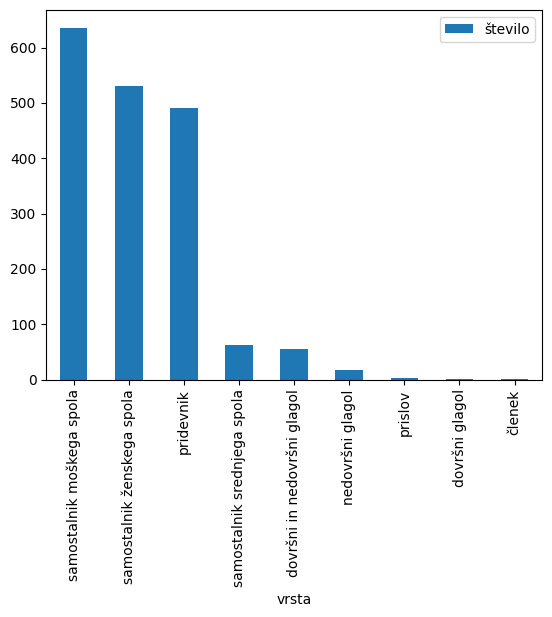

In [41]:
število_vrste.plot.bar()

Kot lahko vidite, to niso le besedna vrste ampak tudi dodatni podatki kot so spol in dovršnost. Zaradi teh dodatnih podatkov težje vidimo koliko je besed posamezne besedne vrste. To lahko spremenimo s pomočjo spodnje funkcije `štetje_vrst()`, ki združi podatke iz stolpca `"vrsta"` v dejanske vrste.

In [110]:
def razpredelnica_vrste(raz, vrsta):
    seznam = raz["vrsta"].apply(lambda x: vrsta in x)
    return raz.loc[seznam]

besedne_vrste = ["samostalnik", "zaimek", "števnik", "pridevnik", "prislov", "glagol"]
raz_vrste = razpredelnica.copy()
for vrsta in besedne_vrste:
    raz_vrste["vrsta"].loc[raz_vrste["vrsta"].apply(lambda x: vrsta in x)] = vrsta
    
    
def štetje_stolpca(raz, stolpec):
    raz = raz.groupby(stolpec)[[stolpec]].agg("count")
    raz.rename(columns={stolpec:"število"}, inplace=True)
    raz.sort_values("število", inplace=True, ascending=False)
    return raz


# raz_vrste
štetje_stolpca(raz_vrste, "vrsta")

,število
vrsta,
samostalnik,1229
pridevnik,490
glagol,74
prislov,3
členek,1


<Axes: >

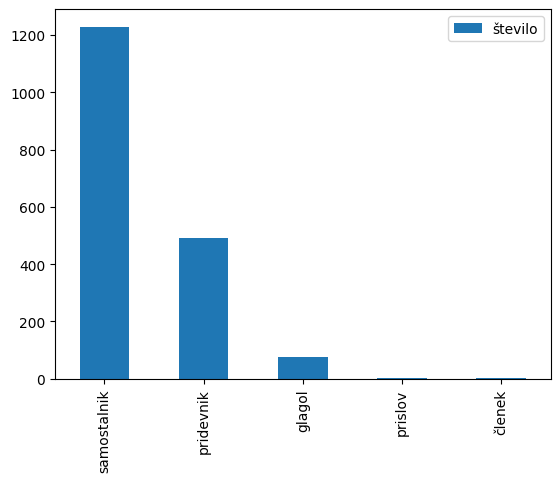

In [7]:
štetje_vrst(razpredelnica).plot.bar()

Sedaj ko smo uspeli ločiti besede na posamezne besedne vrste, lahko iščemo povprečno besedo besedne vrste.
Povprečna beseda je tisti niz črk, za katerega velja, da je njegova dolžina toliko kolikor je povprečje dolžin besed (zaokroženo seveda na celo število) in njegova i-ta črka je tista, ki se največkrat pojavi na i-tem mestu besed. 

In [69]:
def črka_besede(i, beseda):
    if len(beseda)<=i:
        return 
    return beseda[i]

def povprečna_beseda(razpredelnica):
    dolžina = round(razpredelnica["ime"].apply(len).sum()/razpredelnica["ime"].count())
    odg = ""
    for i in range(dolžina):
        seznam = razpredelnica["ime"].apply(lambda beseda: črka_besede(i, beseda))
        crke = Counter(seznam).most_common()
        if crke[0][0] == None:
            odg += crke[1][0]
        else:
            odg += crke[0][0]
    return odg

povprečna_beseda(razpredelnica_samostalnikov)

'antitítta'

Sedaj se osredotočimo le na samostalnike. 

In [68]:
razpredelnica_samostalnikov = razoredelnica_vrste(razpredelnica, "samostalnik")
razpredelnica_samostalnikov


,ime,oblika,vrsta,tonemski_naglas
0,á,--,samostalnik moškega spola,ā
1,à,à,samostalnik moškega spola,ȃ
2,abalienácija,-e,samostalnik ženskega spola,á
4,abbé,-ja,samostalnik moškega spola,ẹ̑ ȇ
5,abc,abecé --,samostalnik moškega spola,ẹ̑; ə̏
...,...,...,...,...
1790,arktíd,-a,samostalnik moškega spola,ȋ
1791,Árktika,-e,samostalnik ženskega spola,á
1792,armáda,-e,samostalnik ženskega spola,ȃ
1794,ármafleks,-a,samostalnik moškega spola,ȃ


In [120]:
# prva_ženska_sklanjatev = razpredelnica_samostalnikov.loc[]
# (razpredelnica_samostalnikov["vrsta"] == "samostalnik ženskega spola") & "-e" in razpredelnica_samostalnikov["oblika"]
# prva_ženska_sklanjatev